<a href="https://colab.research.google.com/github/Battlecruiser1/Plant_analysis/blob/main/Image_architecture_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
# Google Colab에 annotations.xml 업로드
from google.colab import files
uploaded = files.upload()

Saving annotations.xml to annotations.xml


In [ ]:
xml_file = list(uploaded.keys())[0]

In [ ]:
tree = ET.parse(xml_file)
root = tree.getroot()


In [ ]:
# 2. 원하는 subset 필터링 (예: 앞 50개 이미지만)
subset_size = 50
images = root.findall("image")


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
# 4. Polyline 데이터 불러오기
data = []
for img in images:
    img_name = img.get("name")
    w, h = int(img.get("width")), int(img.get("height"))
    for poly in img.findall("polyline"):
        label = poly.get("label")
        points = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
        data.append({"image": img_name, "label": label, "coords": points, "width": w, "height": h})


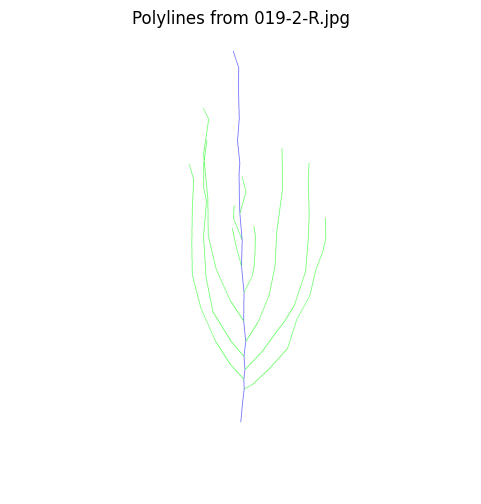

In [ ]:
# 5. 시각화 (예: 첫 이미지)
# 유니크한 이미지 이름만 추출
unique_images = list(dict.fromkeys([d["image"] for d in data]))

# 두 번째 이미지 선택
sample_img = unique_images[9]   # 인덱스 1 → 두 번째 이미지
sample = [d for d in data if d["image"] == sample_img]

canvas = np.ones((sample[0]["height"], sample[0]["width"], 3), dtype=np.uint8) * 255
for d in sample:
    pts = np.array(d["coords"], np.int32).reshape((-1,1,2))
    color = (0,0,255) if d["label"] == "Main" else (0,255,0)
    cv2.polylines(canvas, [pts], isClosed=False, color=color, thickness=2)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.title(f"Polylines from {sample[0]['image']}")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

def polyline_length(coords):
    coords = np.array(coords)
    diffs = np.diff(coords, axis=0)   # 연속된 점들 간 차이
    seg_lengths = np.linalg.norm(diffs, axis=1)  # 각 segment 길이
    return np.sum(seg_lengths)        # 총 길이

In [ ]:
#  이미지 불러오기
first_img = root.findall("image")[45] #첫번째 -> [0]
img_name = first_img.get("name")
print("이미지 이름:", img_name)

# Main stem polyline 찾기
for poly in first_img.findall("polyline"):
    if poly.get("label") == "Main":
        coords = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
        length = polyline_length(coords)
        print("Main stem length:", length)

이미지 이름: 076-5-R.jpg
Main stem length: 1100.2548425628283


In [ ]:
import pandas as pd

In [ ]:
# 앞 50개 이미지 대상으로 반복
records = []
images = root.findall("image")[:50]

for img in images:
    img_name = img.get("name")
    main_length = None

    # Main stem 찾기
    for poly in img.findall("polyline"):
        if poly.get("label") == "Main":
            coords = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
            main_length = polyline_length(coords)

    records.append({"image": img_name, "main_stem_length": main_length})

# DataFrame 생성
df = pd.DataFrame(records)

# 결과 확인
print(df)


          image  main_stem_length
0   002-5-R.jpg       2088.270897
1   003-4-R.jpg       2180.591096
2   005-3-R.jpg       2260.958926
3   007-4-R.jpg       2676.555621
4   008-5-R.jpg       2731.089115
5   009-1-R.jpg       2554.713455
6   015-1-R.jpg       1260.563400
7   016-5-R.jpg       2145.074243
8   018-1-R.jpg       2102.761374
9   019-2-R.jpg       2414.329911
10  020-3-R.jpg       2272.103349
11  021-2-R.jpg       1999.328330
12  025-2-R.jpg       2214.706705
13  028-2-R.jpg       2379.808475
14  031-1-R.jpg       1998.811085
15  032-5-R.jpg       2111.780149
16  033-4-R.jpg       2630.845008
17  034-4-R.jpg       2674.066010
18  035-3-R.jpg        642.340271
19  037-4-R.jpg       2555.578290
20  038-2-R.jpg       2289.100233
21  039-3-R.jpg       2340.527829
22  040-4-R.jpg       2526.368928
23  043-1-R.jpg       2240.798818
24  044-5-R.jpg       2295.137885
25  045-5-R.jpg       2224.325420
26  046-5-R.jpg        652.166218
27  047-2-R.jpg        622.134614
28  050-3-R.jp

In [ ]:
import numpy as np

def branch_angle_local(stem_coords, branch_coords):
    stem_coords = np.array(stem_coords)
    branch_coords = np.array(branch_coords)

    if len(branch_coords) < 2:
        return None

    # branch 시작점
    b0 = branch_coords[0]

    # stem에서 branch 시작점과 가장 가까운 점 찾기
    dists = np.linalg.norm(stem_coords - b0, axis=1)
    i = np.argmin(dists)

    # stem 방향 = i → i+1 (위쪽 방향)
    if i >= len(stem_coords)-1:
        return None
    stem_vec = stem_coords[i+1] - stem_coords[i]

    # branch 방향 = 첫 segment
    branch_vec = branch_coords[1] - branch_coords[0]

    # 내적 → 각도
    cos_theta = np.dot(stem_vec, branch_vec) / (np.linalg.norm(stem_vec)*np.linalg.norm(branch_vec))
    angle = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
    return angle

In [ ]:
#  이미지 불러오기
first_img = root.findall("image")[33] #첫번째 -> [0]
img_name = first_img.get("name")
print("이미지 이름:", img_name)

# Main stem & Branch 좌표 추출
stem_coords, branch_list = None, []
for poly in first_img.findall("polyline"):
    coords = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
    if poly.get("label") == "Main":
        stem_coords = coords
    elif poly.get("label") == "Sub":
        branch_list.append(coords)

print("Number of branches:", len(branch_list))


# branch angle 계산 (y좌표 기준 정렬)
branch_info = []
for b in branch_list:
    angle = branch_angle_local(stem_coords, b)
    if angle is not None:
        y_start = b[0][1]   # branch 시작점의 y좌표
        branch_info.append((y_start, angle))

# y좌표 기준으로 정렬 (# y 큰 값(아래) → 작은 값(위) 순서
branch_info_sorted = sorted(branch_info, key=lambda x: x[0], reverse=True)

angles_sorted = [angle for _, angle in branch_info_sorted]

print("Branch angles (sorted by y):", angles_sorted)
print("Mean branch angle:", np.mean(angles_sorted) if angles_sorted else None)

이미지 이름: 063-1-R.jpg
Number of branches: 3
Branch angles (sorted by y): [np.float64(40.646496822772505), np.float64(70.60335043344594), np.float64(71.43338804821671)]
Mean branch angle: 60.894411768145055


In [ ]:
images = root.findall("image")[:50]   # 앞 50개만

rows = []
for img in images:
    img_name = img.get("name")

    # 좌표 수집
    stem_coords, branch_list = None, []
    for poly in img.findall("polyline"):
        pts = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
        label = poly.get("label")
        if label in ("Main", "main", "MAIN"):
            stem_coords = pts
        elif label in ("Sub", "Branch", "sub", "branch"):
            branch_list.append(pts)

    # 각도 리스트 (branch 시작점 y로 아래→위 정렬하고 싶으면 reverse=True)
    info = []
    for b in branch_list:
        ang = branch_angle_local(stem_coords, b)
        if ang is not None:
            y_start = b[0][1]   # 라벨링을 항상 줄기 접합부부터 클릭했다는 가정
            info.append((y_start, ang))

    # 아래(큰 y) → 위(작은 y) 순 정렬
    info_sorted = sorted(info, key=lambda x: x[0], reverse=True)
    angles_sorted = [a for _, a in info_sorted]

    rows.append({
        "image": img_name,
        "branch_count": len(branch_list),
        "branch_angle_mean": float(np.mean(angles_sorted)) if angles_sorted else np.nan,
        "branch_angles_bottom2top": ",".join(f"{a:.2f}" for a in angles_sorted)  # 확인용(옵션)
    })

df_angles = pd.DataFrame(rows)


In [ ]:
# === 기존 df와 병합 ===
# df : 이미 존재(열: image, main_stem_length) — 없으면 df_angles만 사용하세요.
df_final = df.merge(df_angles, on="image", how="left")
print(df_final.head())

         image  main_stem_length  branch_count  branch_angle_mean  \
0  002-5-R.jpg       2088.270897             6          30.720987   
1  003-4-R.jpg       2180.591096            12          36.984893   
2  005-3-R.jpg       2260.958926            10          39.289078   
3  007-4-R.jpg       2676.555621             5          42.803901   
4  008-5-R.jpg       2731.089115            11          35.277463   

                            branch_angles_bottom2top  
0                26.56,45.87,35.33,25.83,30.99,19.75  
1  37.53,34.98,19.06,59.53,52.56,53.63,36.13,34.7...  
2  38.78,61.02,42.41,55.71,49.10,38.77,36.36,18.8...  
3                      40.96,44.41,37.25,31.56,59.84  
4  67.02,37.85,50.51,40.50,35.91,34.04,34.18,28.0...  


In [ ]:
# 저장
files.download("phenotype_features_50.csv")
print("Saved -> phenotype_features_50.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved -> phenotype_features_50.csv


In [ ]:
Max width (전체 최대 너비)

모든 좌표의 max(x) - min(x).

Left / Right width & Symmetry

정렬된 좌표에서 줄기 중심선(= x=0)을 기준으로 왼쪽/오른쪽 최대폭,

symmetry = |right - left| / (right + left).

Width profile (세로 위치별 폭 분포)

줄기 높이(y)를 균등 구간으로 나눠 각 구간의 max(x)-min(x) → 아래쪽이 더 퍼졌는지, 위쪽이 퍼졌는지 분석 가능.

In [ ]:
import numpy as np

def point_to_polyline_min_dist(p, poly):
    p = np.asarray(p, dtype=float)
    poly = np.asarray(poly, dtype=float)
    if len(poly) == 1:
        return float(np.linalg.norm(p - poly[0]))
    dmin = np.inf
    for i in range(len(poly) - 1):
        a, b = poly[i], poly[i+1]
        ab = b - a
        t = np.clip(np.dot(p - a, ab) / (np.dot(ab, ab) + 1e-12), 0.0, 1.0)
        proj = a + t * ab
        d = np.linalg.norm(p - proj)
        if d < dmin:
            dmin = d
    return float(dmin)

def local_stem_vec_at_point(stem, p):
    stem = np.asarray(stem, dtype=float)
    dists = np.linalg.norm(stem - p, axis=1)
    i = int(np.argmin(dists))
    if i >= len(stem) - 1:
        i = max(0, len(stem) - 2)
    return stem[i+1] - stem[i]

def is_primary_branch_strict(stem_coords, branch_coords, all_branches,
                             tol_attach=8.0, tol_other=8.0, margin=1.5, angle_min_deg=10.0):
    """
    1) stem에 충분히 가까이 붙음 (<= tol_attach)
    2) 다른 가지보다 stem에 더 가깝거나, 다른 가지와는 tol_other 이상 떨어짐
    3) b0->b1로 갈수록 stem과의 거리가 증가 (줄기를 따라가지 않음)
    4) 줄기 국소 벡터와 가지 첫 벡터의 각도가 angle_min 이상
    """
    stem = np.asarray(stem_coords, dtype=float)
    br   = np.asarray(branch_coords, dtype=float)
    if len(stem) < 2 or len(br) < 2:
        return False

    b0, b1 = br[0], br[1]

    # (1) stem 부착 거리
    d_stem = point_to_polyline_min_dist(b0, stem)
    if d_stem > tol_attach:
        return False

    # (2) 다른 가지들과의 거리 비교
    d_other_min = np.inf
    for other in all_branches:
        if other is branch_coords:  # 자기 자신은 제외
            continue
        d_other_min = min(d_other_min, point_to_polyline_min_dist(b0, other))
    # stem 쪽이 더 "가깝다" 또는 타 가지와 충분히 떨어져 있다
    if d_other_min < np.inf:
        if not (d_stem * margin <= d_other_min or d_other_min >= tol_other):
            return False

    # (3) stem으로부터 멀어지는지 검사
    d0 = point_to_polyline_min_dist(b0, stem)
    d1 = point_to_polyline_min_dist(b1, stem)
    if not (d1 > d0):  # 줄기를 따라가면 d1 ≤ d0
        return False

    # (4) 최소 각도 조건
    stem_vec   = local_stem_vec_at_point(stem, b0)
    branch_vec = b1 - b0
    denom = np.linalg.norm(stem_vec) * np.linalg.norm(branch_vec)
    if denom == 0:
        return False
    cos_t = np.dot(stem_vec, branch_vec) / denom
    angle = float(np.degrees(np.arccos(np.clip(cos_t, -1.0, 1.0))))
    if angle < angle_min_deg:
        return False

    return True


In [ ]:
def branch_angle_local(stem_coords, branch_coords):
    stem_coords = np.array(stem_coords, dtype=float)
    branch_coords = np.array(branch_coords, dtype=float)

    if len(branch_coords) < 2 or len(stem_coords) < 2:
        return None

    b0 = branch_coords[0]
    # stem에서 가장 가까운 stem 점
    dists = np.linalg.norm(stem_coords - b0, axis=1)
    i = int(np.argmin(dists))
    if i >= len(stem_coords) - 1:
        return None

    stem_vec   = stem_coords[i+1] - stem_coords[i]
    branch_vec = branch_coords[1] - branch_coords[0]

    denom = np.linalg.norm(stem_vec) * np.linalg.norm(branch_vec)
    if denom == 0:
        return None

    cos_t = np.dot(stem_vec, branch_vec) / denom
    return float(np.degrees(np.arccos(np.clip(cos_t, -1.0, 1.0))))


In [ ]:
rows = []
images = root.findall("image")[:50]

for img in images:
    img_name = img.get("name")

    stem_coords, branch_list = None, []
    for poly in img.findall("polyline"):
        pts = [tuple(map(float, p.split(","))) for p in poly.get("points").split(";")]
        label = poly.get("label")
        if label in ("Main","main","MAIN"):
            stem_coords = pts
        elif label in ("Sub","Branch","sub","branch"):
            branch_list.append(pts)

    angles = []
    for b in branch_list:
        # 강화된 1차-가지 판정
        if not is_primary_branch_strict(stem_coords, b, branch_list,
                                        tol_attach=8.0, tol_other=8.0,
                                        margin=1.5, angle_min_deg=10.0):
            continue
        ang = branch_angle_local(stem_coords, b)
        if ang is not None:
            angles.append(ang)

    rows.append({
        "image": img_name,
        "primary_branch_count": len(angles),                       # 1차 가지 개수
        "primary_branch_angle_mean": np.mean(angles) if angles else np.nan,
        "primary_branch_angles": ",".join(f"{a:.2f}" for a in angles)  # 확인용
    })

df_primary = pd.DataFrame(rows)


In [ ]:
print(df_primary)

          image  primary_branch_count  primary_branch_angle_mean  \
0   002-5-R.jpg                     6                  30.720987   
1   003-4-R.jpg                    12                  36.984893   
2   005-3-R.jpg                    10                  39.289078   
3   007-4-R.jpg                     5                  42.803901   
4   008-5-R.jpg                    11                  35.277463   
5   009-1-R.jpg                     8                  44.559699   
6   015-1-R.jpg                     9                  47.130525   
7   016-5-R.jpg                     7                  49.540944   
8   018-1-R.jpg                    12                  46.818976   
9   019-2-R.jpg                    10                  36.084074   
10  020-3-R.jpg                     3                  42.133178   
11  021-2-R.jpg                     7                  47.255137   
12  025-2-R.jpg                     9                  62.770980   
13  028-2-R.jpg                     8           